In [1]:
import os
import time
import math
import glob
import string
import random 

import torch
import torch.nn as nn

from lstm.helpers import time_since

%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Language recognition with an RNN

If you've ever used an online translator you've probably seen a feature that automatically detects the input language. While this might be easy to do if you input unicode characters that are unique to one or a small group of languages (like "你好" or "γεια σας"), this problem is more challenging if the input only uses the available ASCII characters. In this case, something like "těší mě" would beome "tesi me" in the ascii form. This is a more challenging problem in which the language must be recognized purely by the pattern of characters rather than unique unicode characters.

We will train an RNN to solve this problem for a small set of languages thta can be converted to romanized ASCII form. For training data it would be ideal to have a large and varied dataset in different language styles. However, it is easy to find copies of the Bible which is a large text translated to different languages but in the same easily parsable format, so we will use 20 different copies of the Bible as training data. Using the same book for all of the different languages will hopefully prevent minor overfitting that might arise if we used different books for each language (fitting to common characteristics of the individual books rather than the language).

In [3]:
from unidecode import unidecode as unicodeToAscii

all_characters = string.printable
n_letters = len(all_characters)

print(unicodeToAscii('těší mě'))

tesi me


In [4]:
# Read a file and split into lines
def readFile(filename):
    data = open(filename, encoding='utf-8').read().strip()
    return unicodeToAscii(data)

def get_category_data(data_path):
    # Build the category_data dictionary, a list of names per language
    category_data = {}
    all_categories = []
    for filename in glob.glob(data_path):
        category = os.path.splitext(os.path.basename(filename))[0].split('_')[0]
        all_categories.append(category)
        data = readFile(filename)
        category_data[category] = data
    
    return category_data, all_categories

The original text is split into two parts, train and test, so that we can make sure that the model is not simply memorizing the train data.

In [5]:
train_data_path = 'language_data/train/*_train.txt'
test_data_path = 'language_data/test/*_test.txt'

train_category_data, all_categories = get_category_data(train_data_path)
test_category_data, test_all_categories = get_category_data(test_data_path)

n_languages = len(all_categories)

print(len(all_categories))
print(all_categories)

20
['albanian', 'czech', 'danish', 'english', 'esperanto', 'finnish', 'french', 'german', 'hungarian', 'italian', 'lithuanian', 'maori', 'norwegian', 'portuguese', 'romanian', 'spanish', 'swedish', 'turkish', 'vietnamese', 'xhosa']


# Data processing

In [6]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1, dim=1)
    category_i = top_i[:, 0]
    return category_i

# Turn string into long tensor
def stringToTensor(string):
    tensor = torch.zeros(len(string), requires_grad=True).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

def load_random_batch(text, chunk_len, batch_size):
    input_data = torch.zeros(batch_size, chunk_len).long().to(device)
    target = torch.zeros(batch_size, 1).long().to(device)
    input_text = []
    for i in range(batch_size):
        category = all_categories[random.randint(0, len(all_categories) - 1)]
        line_start = random.randint(0, len(text[category])-chunk_len)
        category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
        line = text[category][line_start:line_start+chunk_len]
        input_text.append(line)
        input_data[i] = stringToTensor(line)
        target[i] = category_tensor
    return input_data, target, input_text

Implement Model
====================

For this classification task, we can use the same model we implement for the generation task which is located in `rnn/model.py`. See the `MP4_P2_generation.ipynb` notebook for more instructions. In this case each output vector of our RNN will have the dimension of the number of possible languages (i.e. `n_languages`). We will use this vector to predict a distribution over the languages.

In the generation task, we used the output of the RNN at every time step to predict the next letter and our loss included the output from each of these predictions. However, in this task we use the output of the RNN at the end of the sequence to predict the language, so our loss function will use only the predicted output from the last time step.



# Train RNN

In [7]:
from lstm.model import LSTM

In [8]:
chunk_len = 25

BATCH_SIZE = 100
n_epochs = 2000
hidden_size = 300
n_layers = 2
learning_rate = 0.001
model_type = 'lstm'

criterion = nn.CrossEntropyLoss()
lstm = LSTM(n_letters, hidden_size, n_languages, model_type=model_type, n_layers=n_layers).to(device)

**TODO:** Fill in the train function. You should initialize a hidden layer representation using your RNN's `init_hidden` function, set the model gradients to zero, and loop over each time step (character) in the input tensor. For each time step compute the output of the of the RNN and the next hidden layer representation. The cross entropy loss should be computed over the last RNN output scores from the end of the sequence and the target classification tensor. Lastly, call backward on the loss and take an optimizer step.

In [9]:
def train(lstm, target_tensor, data_tensor, optimizer, criterion, batch_size=BATCH_SIZE):
    """
    Inputs:
    - rnn: model
    - target_target: target character data tensor of shape (batch_size, 1)
    - data_tensor: input character data tensor of shape (batch_size, chunk_len)
    - optimizer: rnn model optimizer
    - criterion: loss function
    - batch_size: data batch size
    
    Returns:
    - output: output from RNN from end of sequence 
    - loss: computed loss value as python float
    
    """
    
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    batch_size = data_tensor.size(0)
    chunk_len = data_tensor.size(1)
    
    hidden = lstm.init_hidden(batch_size, device = device)
    optimizer.zero_grad()
    
    for i in range(chunk_len):
        output, hidden = lstm(data_tensor[:,i], hidden)
    
    loss = criterion(output, target_tensor.squeeze())
    loss.backward()
    optimizer.step()
    
    ##########       END      ##########
    return output, loss.data.item()
    

In [10]:
def evaluate(lstm, data_tensor, seq_len=chunk_len, batch_size=BATCH_SIZE):
    with torch.no_grad():
        data_tensor = data_tensor.to(device)
        hidden = lstm.init_hidden(batch_size, device=device)
        for i in range(seq_len):
            output, hidden = lstm(data_tensor[:,i], hidden)
        
        return output
    
def eval_test(lstm, category_tensor, data_tensor):
    with torch.no_grad():
        output = evaluate(lstm, data_tensor)
        loss = criterion(output, category_tensor.squeeze())
        return output, loss.data.item()

In [11]:
n_iters = 10000 #1000 #2000 #100000
print_every = 25
plot_every = 25


# Keep track of losses for plotting
current_loss = 0
current_test_loss = 0
all_losses = []
all_test_losses = []

start = time.time()

optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay=0.0005)


number_correct = 0
for iter in range(1, n_iters + 1):
    input_data, target_category, text_data = load_random_batch(train_category_data, chunk_len, BATCH_SIZE)
    output, loss = train(lstm, target_category, input_data, optimizer, criterion)
    current_loss += loss
    
    _, test_loss = eval_test(lstm, target_category, input_data)
    current_test_loss += test_loss
    guess_i = categoryFromOutput(output)
    number_correct += (target_category.squeeze()==guess_i.squeeze()).long().sum()
    
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        sample_idx = 0
        guess = all_categories[guess_i[sample_idx]]
        
        category = all_categories[int(target_category[sample_idx])]
        
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, test_loss, text_data[sample_idx], guess, correct))
        print('Train accuracy: {}'.format(float(number_correct)/float(print_every*BATCH_SIZE)))
        number_correct = 0
    
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        all_test_losses.append(current_test_loss / plot_every)
        current_test_loss = 0
    
    if iter % 200 == 0:
        learning_rate = learning_rate * 0.95

25 0% (0m 2s) 2.6302 2.5436 om du stadig dyrker, han  / english ✗ (norwegian)
Train accuracy: 0.1128
50 0% (0m 4s) 1.9315 1.9308 ad juro Jehova a David, N / italian ✗ (spanish)
Train accuracy: 0.244
75 0% (0m 7s) 1.8365 1.7887 fi groaza, cind vor cadea / spanish ✗ (romanian)
Train accuracy: 0.3108
100 1% (0m 9s) 1.4871 1.4175 te Tama a te tangata. Ka  / maori ✓
Train accuracy: 0.418
125 1% (0m 11s) 1.3415 1.2881 pa haugene. Og Herren slo / german ✗ (norwegian)
Train accuracy: 0.516
150 1% (0m 13s) 1.2430 1.2190 facut Dumnezeu prin El in / romanian ✓
Train accuracy: 0.566
175 1% (0m 16s) 0.8546 0.7799  Herz, das Gebot des HERR / danish ✗ (german)
Train accuracy: 0.6076
200 2% (0m 18s) 0.8518 0.7972 ust: and I cast the dust  / english ✓
Train accuracy: 0.6448
225 2% (0m 20s) 0.7064 0.6598 oi, tuc la xu co mach nha / vietnamese ✓
Train accuracy: 0.6624
250 2% (0m 22s) 0.7351 0.6344 r i dashuri yt se nje i d / albanian ✓
Train accuracy: 0.6916
275 2% (0m 25s) 0.9068 0.8419 u inaintea Tatal

2225 22% (3m 20s) 0.2257 0.1762  Jis man kalbejo: 'Jei ta / lithuanian ✓
Train accuracy: 0.9088
2250 22% (3m 22s) 0.3189 0.2181 menem. Divce, ktera prijd / czech ✓
Train accuracy: 0.9032
2275 22% (3m 24s) 0.3541 0.2967 ue; phai giat quan ao min / vietnamese ✓
Train accuracy: 0.9128
2300 23% (3m 26s) 0.3039 0.2285 em numero, como as estrel / portuguese ✓
Train accuracy: 0.9064
2325 23% (3m 29s) 0.2573 0.1823 o, lukrozo lokuqala ke ol / xhosa ✓
Train accuracy: 0.9016
2350 23% (3m 31s) 0.1825 0.1304 inovo: "Lidsky synu, post / czech ✓
Train accuracy: 0.9004
2375 23% (3m 33s) 0.2856 0.2165 o ne i sviesa. Jis laiko  / lithuanian ✓
Train accuracy: 0.9112
2400 24% (3m 35s) 0.3793 0.2550 n mosiile copiilor lui Is / romanian ✓
Train accuracy: 0.9084
2425 24% (3m 38s) 0.1550 0.0929 i souliers; et ne saluez  / french ✓
Train accuracy: 0.914
2450 24% (3m 40s) 0.1551 0.1121 e Juda habian hecho, y lo / spanish ✓
Train accuracy: 0.9092
2475 24% (3m 42s) 0.2239 0.1882  i te take riri ki ahau,  / maori

4400 44% (6m 34s) 0.1299 0.1034 de los Judios. Este vino  / spanish ✓
Train accuracy: 0.912
4425 44% (6m 36s) 0.2073 0.1819 do mataram a Saul em Gilb / portuguese ✓
Train accuracy: 0.918
4450 44% (6m 38s) 0.1602 0.1401 fanno il male. Egli rende / italian ✓
Train accuracy: 0.922
4475 44% (6m 41s) 0.2407 0.2550 i, mot vai nguoi trong ca / vietnamese ✓
Train accuracy: 0.9264
4500 45% (6m 43s) 0.2079 0.1593 rceiro do reinado do rei  / portuguese ✓
Train accuracy: 0.9216
4525 45% (6m 45s) 0.2380 0.1729  mig bak din rygg; sa bae / norwegian ✓
Train accuracy: 0.9292
4550 45% (6m 47s) 0.2192 0.2191 awawathethayo kukumkani,  / xhosa ✓
Train accuracy: 0.9144
4575 45% (6m 50s) 0.2574 0.1911  mesa, e poras em ordem o / portuguese ✓
Train accuracy: 0.9124
4600 46% (6m 52s) 0.3005 0.2072 'Ka jus turite bendro su  / lithuanian ✓
Train accuracy: 0.9184
4625 46% (6m 54s) 0.2911 0.2397 e uni, niin mina tiedan,  / finnish ✓
Train accuracy: 0.912
4650 46% (6m 56s) 0.4555 0.3102 e mis rebeliones esta lig /

6600 66% (9m 51s) 0.2046 0.1940  lai noi run bien. Quan n / vietnamese ✓
Train accuracy: 0.9156
6625 66% (9m 54s) 0.1499 0.1468  a Lehi, i Filistei gli s / italian ✓
Train accuracy: 0.9256
6650 66% (9m 56s) 0.2288 0.1771 mme natt kom Guds ord til / norwegian ✓
Train accuracy: 0.9352
6675 66% (9m 58s) 0.3451 0.3228 omme nous, la voix du Die / french ✓
Train accuracy: 0.926
6700 67% (10m 0s) 0.2491 0.2009  est une lampe, l'enseign / french ✓
Train accuracy: 0.9268
6725 67% (10m 3s) 0.1782 0.1455 , kili, gumusu, altini pa / turkish ✓
Train accuracy: 0.928
6750 67% (10m 5s) 0.1552 0.1550 j batalarangxigxis antaux / esperanto ✓
Train accuracy: 0.9364
6775 67% (10m 7s) 0.2907 0.2686 i uma voz que nao conheci / portuguese ✓
Train accuracy: 0.9324
6800 68% (10m 9s) 0.3121 0.2564 e, jeho predvoj do more v / czech ✓
Train accuracy: 0.918
6825 68% (10m 12s) 0.0894 0.0920 an se. Da sade grannarna  / swedish ✓
Train accuracy: 0.9312
6850 68% (10m 14s) 0.1094 0.1030 na iho e ia te ingoa ko I / maori

8800 88% (13m 9s) 0.2629 0.2122 r. Bundan dolayi Israil h / turkish ✓
Train accuracy: 0.944
8825 88% (13m 11s) 0.2268 0.1756  krejt krahinen malore te / albanian ✓
Train accuracy: 0.932
8850 88% (13m 13s) 0.1753 0.1012 chaumte. Und er fragte se / german ✓
Train accuracy: 0.9348
8875 88% (13m 15s) 0.1416 0.1278 de mao e as lancas; acend / portuguese ✓
Train accuracy: 0.9268
8900 89% (13m 18s) 0.1719 0.1152 im>> dedi. Boylece ikisi  / turkish ✓
Train accuracy: 0.9376
8925 89% (13m 20s) 0.2270 0.1549 tarnauja Dievui. Jie jums / lithuanian ✓
Train accuracy: 0.9324
8950 89% (13m 22s) 0.2937 0.2000 unu bana ayir. Israillile / turkish ✓
Train accuracy: 0.9352
8975 89% (13m 24s) 0.2009 0.1705 orran man holjde over Ham / swedish ✓
Train accuracy: 0.9344
9000 90% (13m 27s) 0.1975 0.1085 en el libro de las cronic / spanish ✓
Train accuracy: 0.9276
9025 90% (13m 29s) 0.1566 0.1498 ricxulojn kaj pereigi la  / esperanto ✓
Train accuracy: 0.9256
9050 90% (13m 31s) 0.2882 0.2144 n dem. Og porten til d

Plot loss functions
--------------------



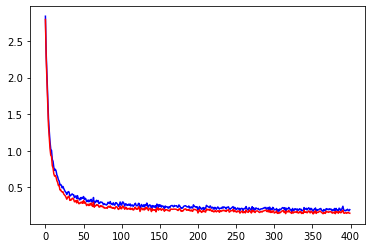

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses, color='b')
plt.plot(all_test_losses, color='r')

Evaluate results
-------------------

We now vizualize the performance of our model by creating a confusion matrix. The ground truth languages of samples are represented by rows in the matrix while the predicted languages are represented by columns.

In this evaluation we consider sequences of variable sizes rather than the fixed length sequences we used for training.

Test accuracy:  0.896


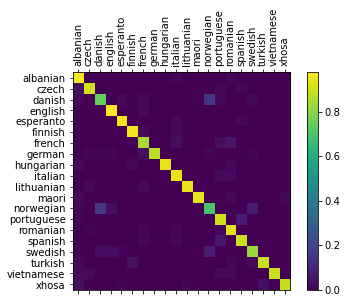

In [13]:
eval_batch_size = 1  # needs to be set to 1 for evaluating different sequence lengths

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_languages, n_languages)
n_confusion = 1000
num_correct = 0
total = 0

for i in range(n_confusion):
    eval_chunk_len = random.randint(10, 50) # in evaluation we will look at sequences of variable sizes
    input_data, target_category, text_data = load_random_batch(test_category_data, chunk_len=eval_chunk_len, batch_size=eval_batch_size)
    output = evaluate(lstm, input_data, seq_len=eval_chunk_len, batch_size=eval_batch_size)
    
    guess_i = categoryFromOutput(output)
    category_i = [int(target_category[idx]) for idx in range(len(target_category))]
    for j in range(eval_batch_size):
        category = all_categories[category_i[j]] 
        confusion[category_i[j]][guess_i[j]] += 1
        num_correct += int(guess_i[j]==category_i[j])
        total += 1

print('Test accuracy: ', float(num_correct)/float(n_confusion*eval_batch_size))

# Normalize by dividing every row by its sum
for i in range(n_languages):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly.




Run on User Input
---------------------

Now you can test your model on your own input. 


In [14]:
def predict(input_line, n_predictions=5):
    print('\n> %s' % input_line)
    with torch.no_grad():
        input_data = stringToTensor(input_line).long().unsqueeze(0).to(device)
        output = evaluate(lstm, input_data, seq_len=len(input_line), batch_size=1)

    # Get top N categories
    topv, topi = output.topk(n_predictions, dim=1)
    predictions = []

    for i in range(n_predictions):
        topv.shape
        topi.shape
        value = topv[0][i].item()
        category_index = topi[0][i].item()
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('This is a phrase to test the model on user input')



> This is a phrase to test the model on user input
(11.74) english
(2.80) albanian
(1.39) french
(0.76) spanish
(0.57) german


# Output Kaggle submission file

Once you have found a good set of hyperparameters submit the output of your model on the Kaggle test file.

In [15]:
import csv

kaggle_test_file_path = 'kaggle_rnn_language_classification_test.txt'
with open(kaggle_test_file_path, 'r') as f:
    lines = f.readlines()

output_rows = []
for i, line in enumerate(lines):
    sample = line.rstrip()
    sample_chunk_len = len(sample)
    input_data = stringToTensor(sample).unsqueeze(0)
    output = evaluate(lstm, input_data, seq_len=sample_chunk_len, batch_size=1)
    guess_i = categoryFromOutput(output)
    output_rows.append((str(i+1), all_categories[guess_i]))

submission_file_path = 'kaggle_rnn_submission.txt'
with open(submission_file_path, 'w') as f:
    output_rows = [('id', 'category')] + output_rows
    writer = csv.writer(f)
    writer.writerows(output_rows)
